### Data Analysis

Here I'll assume the reader is familiar with the Cold Start data and the goals of the competition. If that is not the case please look at the Intro and "First Look at Data.ipynb" notebook.

Now I will try to gain some insights into the energy usage patterns of the various buildings contained in the data. I will not try to build any models in this notebook, although I may create some new features that may be used in later models.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt

In [313]:
# building metadata
meta = pd.read_csv('data/meta.csv')
# building energy consumption
consumption = pd.read_csv('data/consumption_train.csv')

In [314]:
meta.head(2)

,series_id,surface,base_temperature,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off
0,100003,x-large,low,False,False,False,False,False,True,True
1,100004,x-large,low,False,False,False,False,False,True,True


In [315]:
consumption.head(2)

,Unnamed: 0,series_id,timestamp,consumption,temperature
0,0,103088,2014-12-24 00:00:00,101842.233424,NaN
1,1,103088,2014-12-24 01:00:00,105878.048906,NaN


### Format Timestamps and Merge Data

Before we do any analysis we need to convert the timestamp from string to datetime. We also want to merge surface and base temp data from meta with the consumption data.

In [316]:
consumption['timestamp']=pd.to_datetime(consumption.timestamp)

It will also be useful to have columns for various components of the time data.

In [329]:
consumption['year']=consumption.timestamp.dt.year
consumption['month']=consumption.timestamp.dt.month
consumption['weekday']=consumption.timestamp.dt.weekday # Monday is 0
consumption['hour']=consumption.timestamp.dt.hour

In [331]:
df = pd.merge(consumption,meta[['series_id','surface','base_temperature']],on='series_id').drop('Unnamed: 0',axis=1)
df.head(3)

,series_id,timestamp,consumption,temperature,year,month,weekday,hour,surface,base_temperature
0,103088,2014-12-24 00:00:00,101842.233424,NaN,2014,12,2,0,x-small,low
1,103088,2014-12-24 01:00:00,105878.048906,NaN,2014,12,2,1,x-small,low
2,103088,2014-12-24 02:00:00,91619.105008,NaN,2014,12,2,2,x-small,low


### Basic Quantities

In [370]:
counts = df[['surface','series_id']].groupby('surface').nunique().drop('surface',axis=1)
counts['temp']=df.groupby('surface').count().consumption
counts.columns=['Building Count','Hours of Consumption Data']
counts = counts.reindex(index=['xx-small','x-small','small','medium','large','x-large','xx-large'])

In [371]:
counts.append(counts.sum().to_frame(name='Total').T)

,Building Count,Hours of Consumption Data
xx-small,95,63840
x-small,169,113568
small,76,51072
medium,88,59136
large,53,35616
x-large,218,146496
xx-large,59,39648
Total,758,509376


### Consumption vs Month

The first thing we might want to know is how energy consumption varies over different timescales. To do this we can start by splitting the timestamp column into year month weekday and hour.

Now we can create some plots.

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

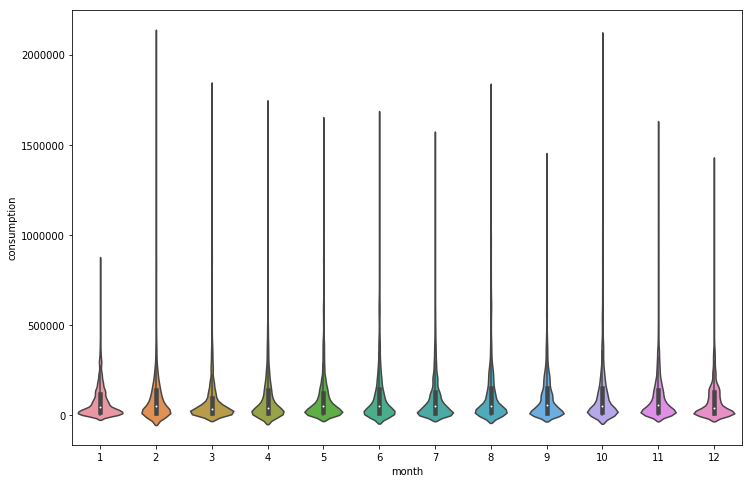

In [9]:
fig, ax = plt.subplots(figsize=[12,8])
sns.violinplot(ax=ax,x='month',y='consumption',data=consumption)

We can see from the plot that the data is highly skewed. Perhaps this is due to different sizes of buildings and differences in base temperature. In order to investigate this we need to merge the metadata with the consumption data.

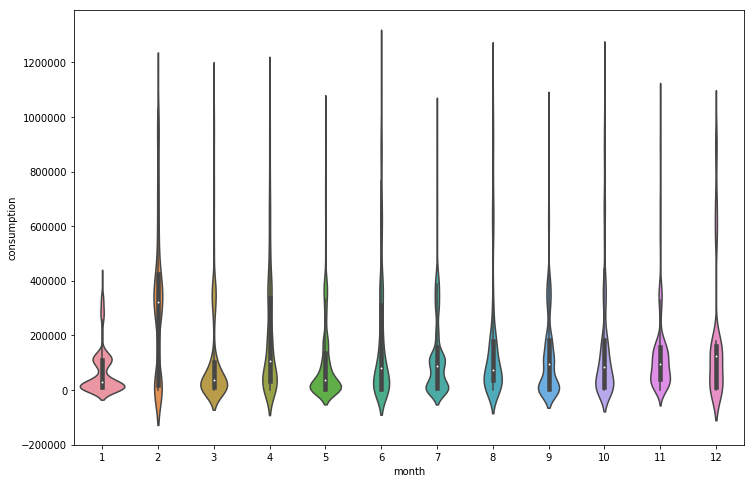

In [12]:
fig, ax = plt.subplots(figsize=[12,8])
sns.violinplot(ax=ax,x='month',y='consumption',data=df[(df.surface=='small')&(df.base_temperature=='low')])

In this plot we are only looking at small buildings with low base temp. We still see the data is highly skewed, and in certain months, multi-modal. As the remaining violin plots below show, the data for nearly every subgroup is not normal. Clearly there is a lot of variety in energy usage of buildings and we do not have the hidden variables to indicate what type of buildings we are investigating.


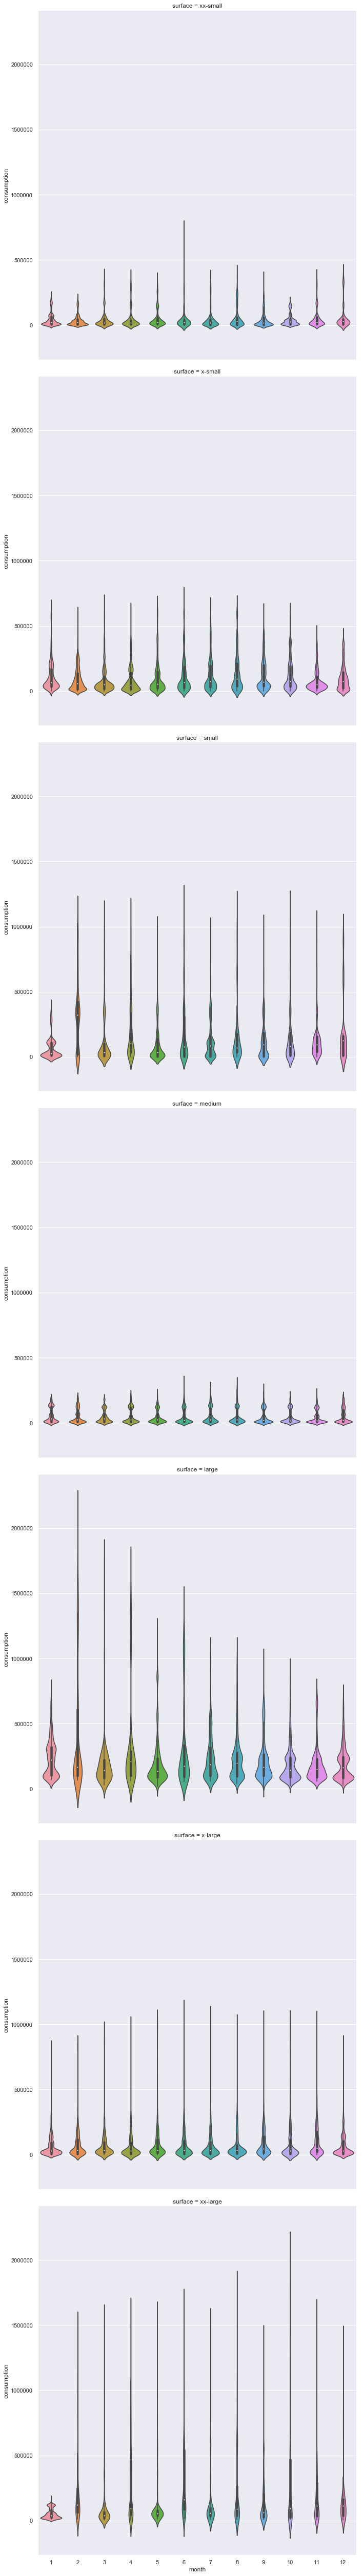

In [21]:
sizes = ['xx-small','x-small','small','medium','large','x-large','xx-large']
sns.set(font_scale=1)
p = sns.catplot(x='month',y='consumption',data=df[df.base_temperature=='low'],kind='violin',row='surface',row_order=sizes,height=10)

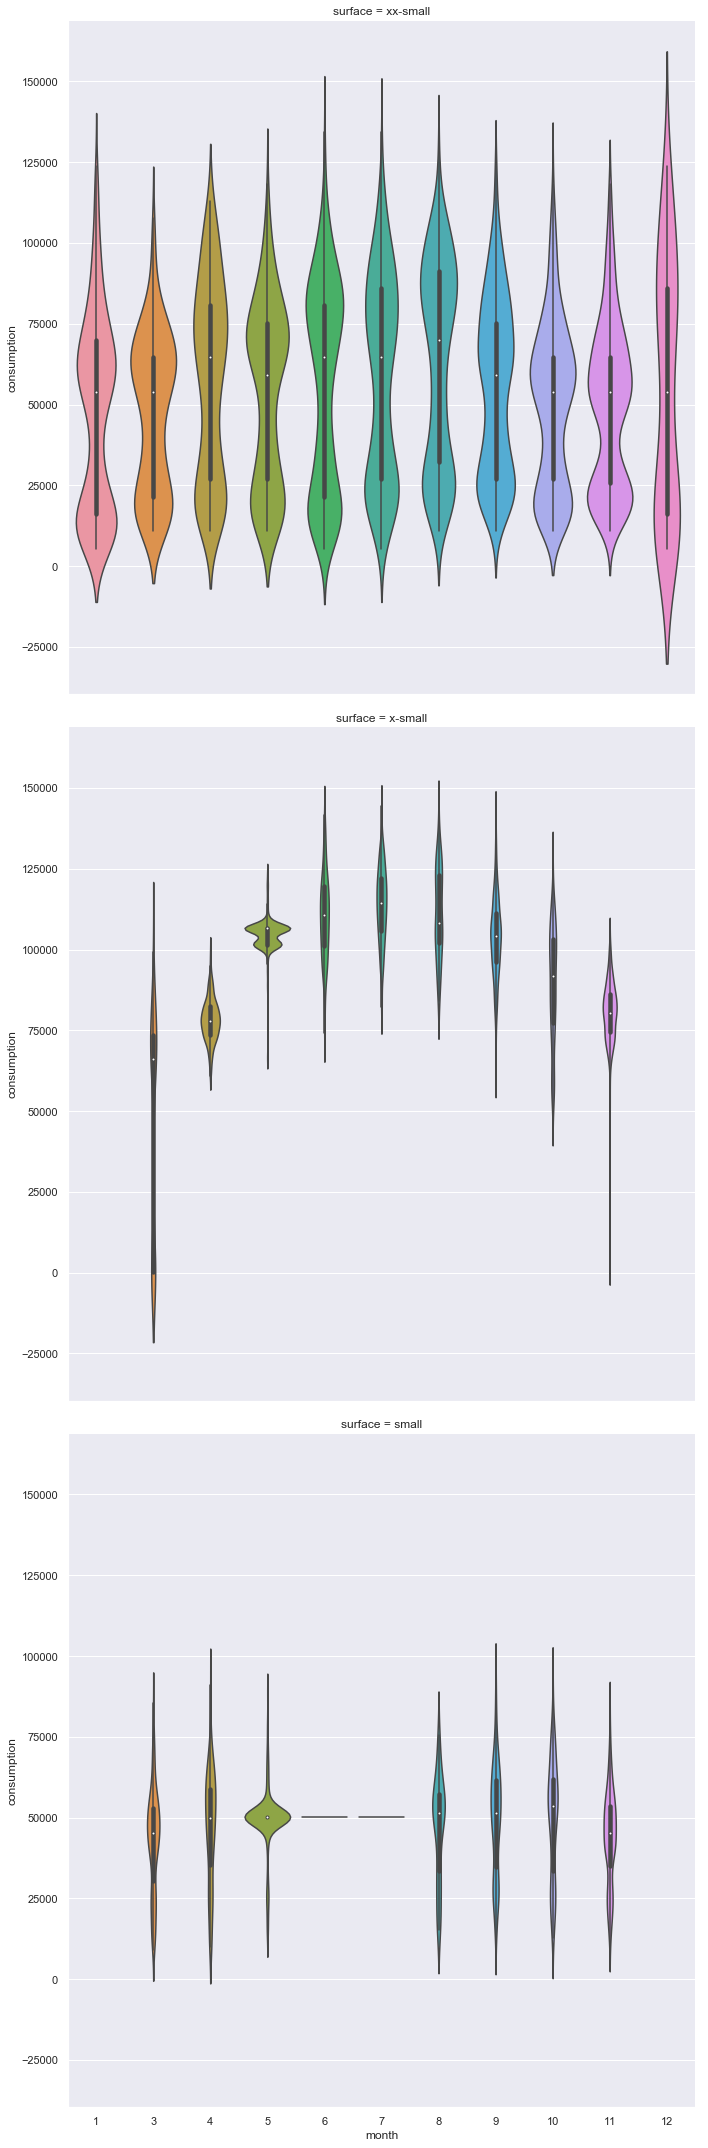

In [23]:
sns.set(font_scale=1)
p = sns.catplot(x='month',y='consumption',data=df[df.base_temperature=='high'],kind='violin',row='surface',height=10)

The good news is that we now have a merged data set with meta data and time data, so we can look for patterns in other time scales for seperate time scales.

### Consumption vs Hour

Here we see that for small buildings with low base temperature, the data follows a reasonable pattern of low consumption at night and high consumption during the day.

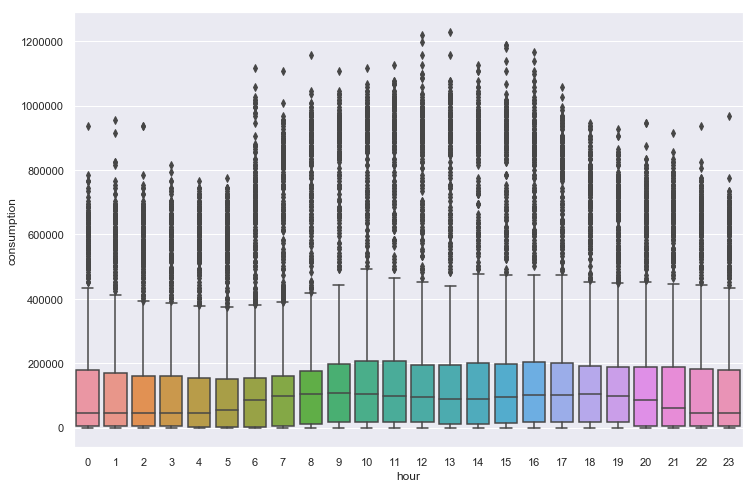

In [26]:
fig, ax = plt.subplots(figsize=[12,8])
sns.boxplot(ax=ax,x='hour',y='consumption',data=df[(df.surface=='small')&(df.base_temperature=='low')])

In [34]:
day_start, day_end = (7,19)
night_start, night_end = (20,6)
day_median = df[(df.surface=='small')&(df.base_temperature=='low')&(df.hour.between(day_start,day_end))].consumption.median()
night_median = df[(df.surface=='small')&(df.base_temperature=='low')&(df.hour.between(night_end,night_start))==0].consumption.median()

print('Median consumption from %d to %d : %.2f' % (day_start,day_end,day_median))
print('Median consumption from %d to %d : %.2f' % (night_start,night_end,night_median))

Median consumption from 7 to 19 : 98508.88
Median consumption from 20 to 6 : 48411.62


### Temperature Imputation

One problem with the data set is that there is a lot of missing temperature data. However, there are still over 280,000 data points with temperature data, corresponding to 508 buildings. Perhaps we can impute some of the missing temperature data.

In [154]:
print_vars = (df.temperature.count(),
              len(df),
              100*df.temperature.count()/len(df),
              df.dropna(subset=['temperature'])['series_id'].nunique(),
              df['series_id'].nunique(),
              100*df.dropna(subset=['temperature'])['series_id'].nunique()/df['series_id'].nunique())
              
print(' %d out of %d rows have temperature data (%.1f pct). \n %d out of %d buildings have at least partial temperature data (%.1f pct).' % print_vars )


 280687 out of 509376 rows have temperature data (55.1 pct). 
 508 out of 758 buildings have at least partial temperature data (67.0 pct).


In [146]:
df['missing_temp']=df.temperature.isna().apply(int)

So we may be able to use interpolation to impute some reliable temperature data. Let's see how many series have over 50% temperature data recorded.

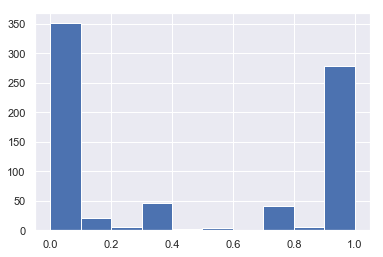

In [148]:
fraction_missing = df.groupby('series_id').missing_temp.mean()
fraction_missing.hist()

This is somewhat promising. The bars on the left indicate there are series with less than half the temperatures missing. There is potential to interpolate if the missing data is scattered in the series. Unfortunately, this is not the case, as we see in some examples below, the missing temperature data occurs in long stretches, even in series with a small fraction of missing data.

In [191]:
fraction_missing[fraction_missing.between(0.1,0.2)].head()

series_id
100755    0.177083
100819    0.175595
100836    0.181548
100904    0.184524
101111    0.141369
Name: missing_temp, dtype: float64

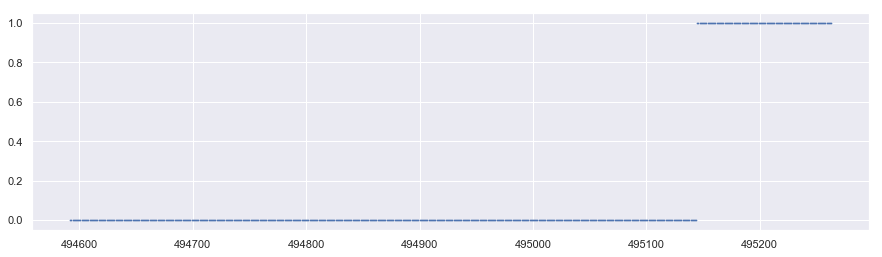

In [202]:
plt.figure(figsize=(15,4))
plt.scatter(df[df.series_id==100755].index,df[df.series_id==100755].missing_temp,s=0.5)

Some series appear to be more scrambled, as we see below, but upon inspection we see that the stretches of missing and non-missing temperature data are still almost always longer than 8 hours. this is too large a gap for imputation to reliably fill in details.

In [194]:
fraction_missing[fraction_missing.between(0.4,0.5)].head()

series_id
102253    0.418155
102597    0.458333
102956    0.459821
Name: missing_temp, dtype: float64

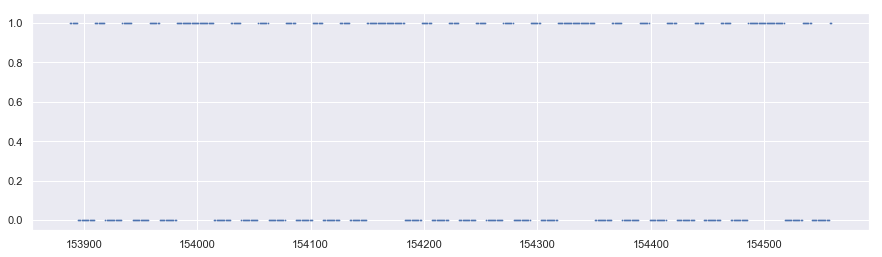

In [204]:
plt.figure(figsize=(15,4))
plt.scatter(df[df.series_id==102956].index,df[df.series_id==102956].missing_temp,s=0.5)

In [208]:
chunk_sizes = [0]
missing = True 
for b in df[df.series_id==102956].temperature.isna():
    if b == missing:
        chunk_sizes[-1] +=1
    else:
        missing = not missing
        chunk_sizes.append(1)

print(chunk_sizes)

[7, 15, 9, 15, 9, 15, 9, 15, 33, 15, 9, 15, 9, 15, 9, 15, 9, 15, 9, 15, 33, 15, 9, 15, 9, 15, 9, 15, 9, 15, 9, 15, 33, 15, 9, 15, 9, 15, 9, 16, 8, 15, 9, 15, 32, 16, 8, 16, 2]


### Temperature vs Consumption

There is still plenty of temperature data to make use of as we look for insights into energy consumption. The plot below shows consumption vs temperature for 61 small buildings around noon. It's a fairly interesting plot in that several clusters are evident. This gives us some clue as to what may be hidden categories of buildings.

In [209]:
condition = (df.hour.between(10,14))&(df.surface=='small')
tempdf = df[condition].dropna(subset=['temperature'])
tempdf['series_id'].nunique()

61

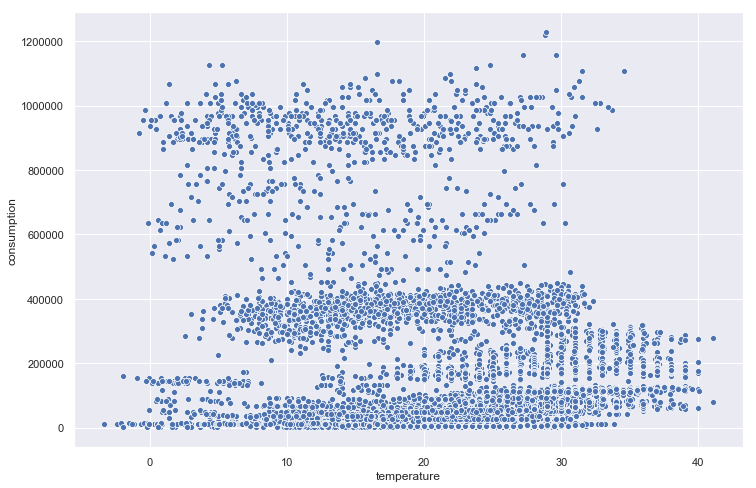

In [96]:
fig, ax = plt.subplots(figsize=[12,8])
sns.scatterplot(ax=ax,x='temperature',y='consumption',data=tempdf)

Let's try to isolate the building belonging to the group in the middle that clusters around 400,000

In [97]:
bySeriesID = tempdf.groupby('series_id')

In [98]:
cluster = pd.DataFrame(bySeriesID['consumption'].mean().between(300000,500000))
cluster = cluster.reset_index()
cluster.columns=['series_id','flag']
cluster.head(3)

,series_id,flag
0,100088,False
1,100287,False
2,100295,False


There are seven series id's (presumably seven buildings) that are small, have temperature data, and consume an hourly average around 400000 in the midday

In [99]:
cluster.flag.sum()

7

In [100]:
tempdf = pd.merge(tempdf,cluster,on='series_id')

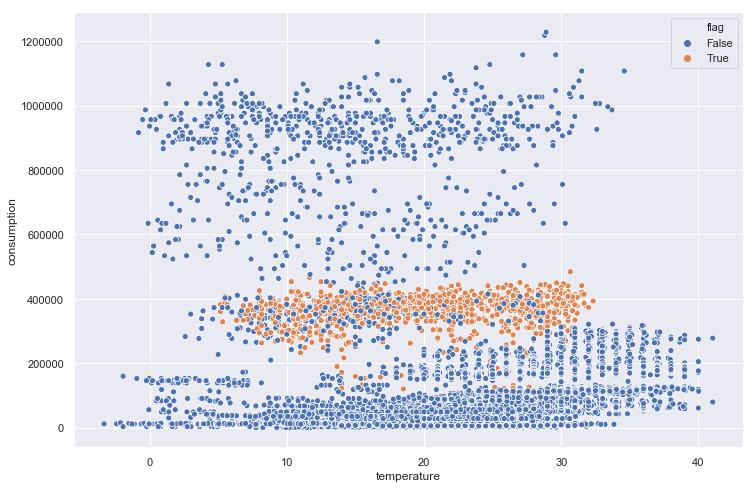

In [101]:
fig, ax = plt.subplots(figsize=[12,8])
sns.scatterplot(ax=ax,x='temperature',y='consumption',data=tempdf,hue='flag')

The hunch that this cluster would come from a subset of the series ID's was correct. Unfortunately, the subset is only seven buildings, so it would probably not be worthwhile to make use of this in a predictive model.

### Correlated Consumption Data

Another avenue of attack is to try and find buildings with overlapping time frames and check for correlation. This is a very computationally expensive approach, but there is good potential to find hidden connections between buildings. For instance, if two buildings have highly correlated consumption then they may be located near each other.

The code below checks all possible pairings of medium sized buildings for overlapping time frames and calculates the correlation of their consumption data. 

In [229]:
medium_buildings = df[df.surface=='medium'].series_id.unique()
len(medium_buildings)

88

In [216]:
def get_common_dates(building1,building2):
    set1 = set(df[df.series_id==building1].timestamp)
    set2 = set(df[df.series_id==building2].timestamp)
    return pd.Series(list(set1 & set2))

In [284]:
from itertools import combinations

In [295]:
corrs = []
for b1,b2 in combinations(medium_buildings,2):
    dates = get_common_dates(b1,b2)
    if len(dates)>30:
        s1 = df[(df.series_id==b1)&df.timestamp.isin(dates)].reset_index().consumption
        s2 = df[(df.series_id==b2)&df.timestamp.isin(dates)].reset_index().consumption
        corrs.append([b1,b2,s1.corr(s2)])
corrs = pd.DataFrame(corrs,columns=['id1','id2','correlation'])
corrs[corrs.correlation>0.90]

,id1,id2,correlation
71,101403,101328,0.936801
78,100729,100940,0.941858
150,103442,102972,0.911602
159,100425,102972,0.908528
172,102670,101885,0.952394
218,103082,103582,0.922594


Above we see the most correlated building pairs (Pearson Coefficient greater than 0.9). 

Below is a scatter plot with regression line for two of the buildings listed in the table (100729 and 100940).

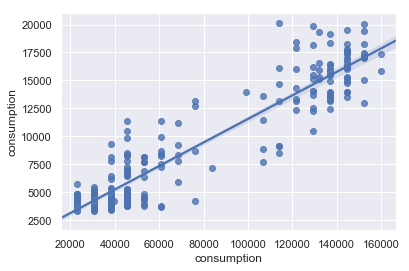

In [298]:
b1,b2 = (100729,100940)
dates = get_common_dates(b1,b2)
s1 = df[(df.series_id==b1)&df.timestamp.isin(dates)].reset_index().consumption
s2 = df[(df.series_id==b2)&df.timestamp.isin(dates)].reset_index().consumption

sns.regplot(x=s1,y=s2)

As mentioned before, highly correlated consumption data could indicate that two buildings experienced similar temperature fluctuations. This is more or less what we can see below in the plot of each building's temperature data. Note the similarity of the overlapping sections.

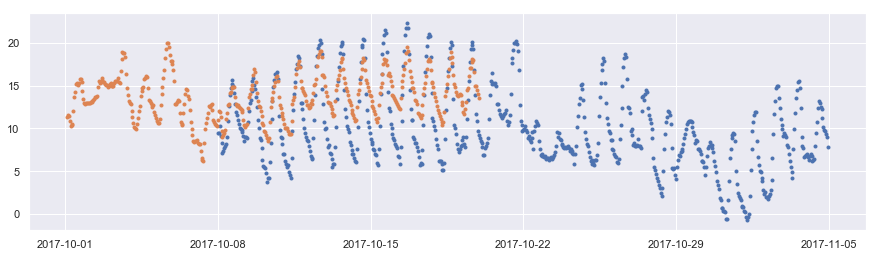

In [308]:
foo1 = df[df.series_id==b1]
plt.figure(figsize=(15,4))
plt.plot_date(foo1.timestamp,foo1.temperature,fmt='.')
foo2 = df[df.series_id==b2]
plt.plot_date(foo2.timestamp,foo2.temperature,fmt='.')


This notebook has been an overview of possible avenues of analysis and is by no means systematic or complete. I will certainly be updating it and hopefully gaining more useful insights. In the final notebook I will implement a neural network to predict energy consumption.